### 北京空气污染预测

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

#### 数据处理

In [2]:
data = pd.read_csv('./dataset/air.csv')

In [3]:
data = data.iloc[24:].fillna(method='ffill')
data['pm2.5'].isna().sum()

0

In [4]:
data['time'] = data.apply(lambda x: datetime.datetime(year=x['year'], month=x['month'], day=x['day'], hour=x['hour']), axis=1)

In [5]:
data.drop(columns=['year', 'month', 'day', 'hour', 'No'], inplace=True)
data.set_index('time', inplace=True)
data

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
time,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [6]:
data = data.join(pd.get_dummies(data.cbwd))
del data['cbwd']

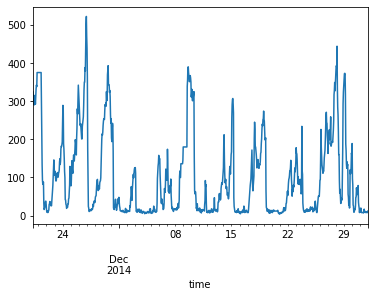

In [7]:
data['pm2.5'][-1000:].plot()

In [8]:
seq_length = 5*24
delay = 24

In [9]:
data_ = []
for i in range(len(data)-seq_length-delay):
    data_.append(data.iloc[i:i+seq_length+delay])

In [10]:
data_ = np.array([df.values for df in data_])

In [11]:
np.random.shuffle(data_)

In [12]:
# 划分train和label
x = data_[:, :5*24, :]
y = data_[:, -1, 0]

# 划分测试数据和训练数据
split = int(data.shape[0]*0.8)
train_x = x[:split]
train_y = y[:split]
test_x = x[split:]
test_y = y[split:]

In [13]:
# 数据标准化 减均值 除方差
mean = train_x.mean(axis=0)
std = train_x.std(axis=0)
train_x = (train_x - mean) / std

In [14]:
test_x = (test_x - mean) / std

#### 模型建立

In [15]:
batch_size = 128

In [16]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(32, input_shape=train_x.shape[1:], activation="tanh", return_sequences=True))
model.add(tf.keras.layers.LSTM(32, activation="tanh", return_sequences=True))
model.add(tf.keras.layers.LSTM(32, activation="tanh", return_sequences=True))
model.add(tf.keras.layers.LSTM(32, activation="tanh" ))
model.add(tf.keras.layers.Dense(1))

In [17]:
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau('val_loss', patience=3, factor=0.5, min_lr=0.0001)

In [18]:
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [19]:
model.fit(train_x, train_y, batch_size=batch_size, epochs=200, validation_data=(test_x, test_y), callbacks=[lr_reduce])

Train on 35040 samples, validate on 8616 samples
Epoch 1/200
15104/35040 [===========>..................] - ETA: 38s - loss: 16726.5127 - mae: 91.3608WARNING:tensorflow:Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,lr


KeyboardInterrupt: 